In [1]:
pip install -r "..\requirements.txt"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Train-Accuracy: 0.912
 Test-Accuracy: 0.910


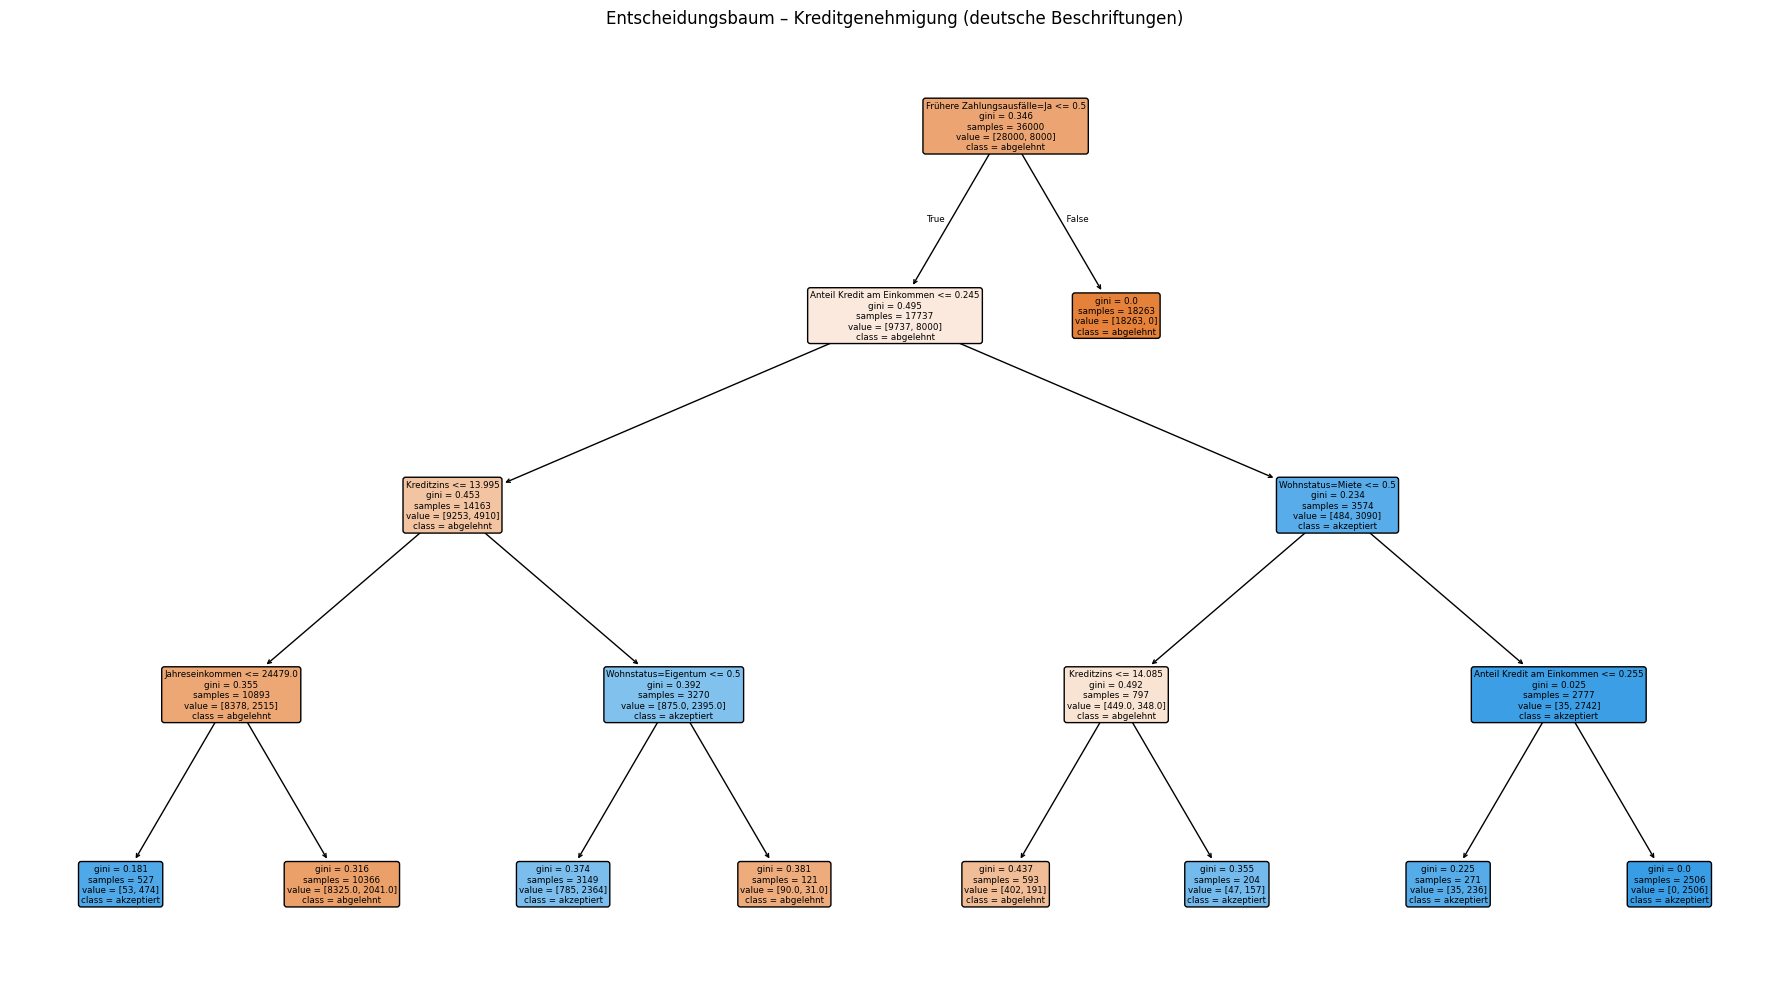

PNG gespeichert unter: C:\Users\JuliusSchmidt\Desktop\Modelle und Datenanalyse Masterarbeit\XAI-Modelle\entscheidungsbaum_kredit.png


In [3]:
# Entscheidungsbaum für loan_data.csv – deutsche Beschriftungen (ohne Graphviz)
# Voraussetzungen: pandas, scikit-learn, matplotlib

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# ===== 1) CSV laden =====
CSV_PATH = "loan_data.csv"  # liegt im selben Ordner wie das Notebook/Script
df = pd.read_csv(CSV_PATH)

TARGET = "loan_status"  # 0=rejected, 1=approved
# Zielspalte robust in int umwandeln (falls als string in der Datei)
if df[TARGET].dtype != int:
    df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").astype("Int64").fillna(0).astype(int)

# ===== 2) Spalten nach Datentypen (gemäß Screenshot) =====
categorical_cols = [
    "person_gender",
    "person_education",
    "person_home_ownership",
    "loan_intent",
    "previous_loan_defaults_on_file",
]
all_cols = [c for c in df.columns if c != TARGET]
numeric_cols = [c for c in all_cols if c not in categorical_cols]

# ===== 3) Preprocessing =====
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

# ===== 4) Modell =====
clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("tree", DecisionTreeClassifier(
            criterion="gini", max_depth=4, random_state=42
        )),
    ]
)

X = df.drop(columns=[TARGET])
y = df[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf.fit(X_train, y_train)

print(f"Train-Accuracy: {clf.score(X_train, y_train):.3f}")
print(f" Test-Accuracy: {clf.score(X_test, y_test):.3f}")

# ===== 5) Deutsche Feature-Namen erzeugen =====
# a) Basis-Übersetzungen für Rohspalten
de_map = {
    "person_age": "Alter",
    "person_gender": "Geschlecht",
    "person_education": "Bildungsgrad",
    "person_income": "Jahreseinkommen",
    "person_emp_exp": "Berufserfahrung (Jahre)",
    "person_home_ownership": "Wohnstatus",
    "loan_amnt": "Kredithöhe",
    "loan_intent": "Kreditabsicht",
    "loan_int_rate": "Kreditzins",
    "loan_percent_income": "Anteil Kredit am Einkommen",
    "cb_person_cred_hist_length": "Kreditvergangenheit (Jahre)",
    "credit_score": "Kredit-Score",
    "previous_loan_defaults_on_file": "Frühere Zahlungsausfälle",
}

# b) Übersetzungen für häufige Kategorien (für schönere One-Hot-Namen)
val_map = {
    "male": "männlich",
    "female": "weiblich",
    "Yes": "Ja",
    "No": "Nein",
    "RENT": "Miete",
    "MORTGAGE": "Hypothek",
    "OWN": "Eigentum",
    "OTHER": "Sonstiges",
    "PERSONAL": "Persönlich",
    "EDUCATION": "Bildung",
    "MEDICAL": "Medizinisch",
    "DEBTCONSOLIDATION": "Schuldenkonsolidierung",
    "VENTURE": "Unternehmensgründung",
    "HOMEIMPROVEMENT": "Hausverbesserung",
}

# Feature-Namen nach dem Preprocessing (One-Hot erzeugt zusätzliche Spalten)
ct = clf.named_steps["preprocess"]
feature_names_out = ct.get_feature_names_out()

def germanize_feature_name(name: str) -> str:
    # Beispiele für Namen:
    # "num__credit_score" -> "Kredit-Score"
    # "cat__loan_intent_DEBTCONSOLIDATION" -> "Kreditabsicht=Schuldenkonsolidierung"
    if "__" in name:
        _, raw = name.split("__", 1)
    else:
        raw = name

    if "_" in raw and any(raw.startswith(col + "_") for col in categorical_cols):
        # One-Hot-Feature: <col>_<value>
        col = None
        for c in categorical_cols:
            if raw.startswith(c + "_"):
                col = c
                break
        val = raw[len(col) + 1:]
        col_de = de_map.get(col, col)
        val_de = val_map.get(val, val)
        return f"{col_de}={val_de}"
    else:
        # Numerisches Originalfeature
        return de_map.get(raw, raw)

feature_names_de = [germanize_feature_name(n) for n in feature_names_out]

# ===== 6) Baum visualisieren (deutsche Labels) =====
plt.figure(figsize=(18, 10))
plot_tree(
    clf.named_steps["tree"],
    feature_names=feature_names_de,
    class_names=["abgelehnt", "akzeptiert"],
    filled=True,
    rounded=True,
    impurity=True,
)
plt.title("Entscheidungsbaum – Kreditgenehmigung (deutsche Beschriftungen)")
plt.tight_layout()

OUT = Path("entscheidungsbaum_kredit.png")
plt.savefig(OUT, dpi=220, bbox_inches="tight")
plt.show()
print(f"PNG gespeichert unter: {OUT.resolve()}")


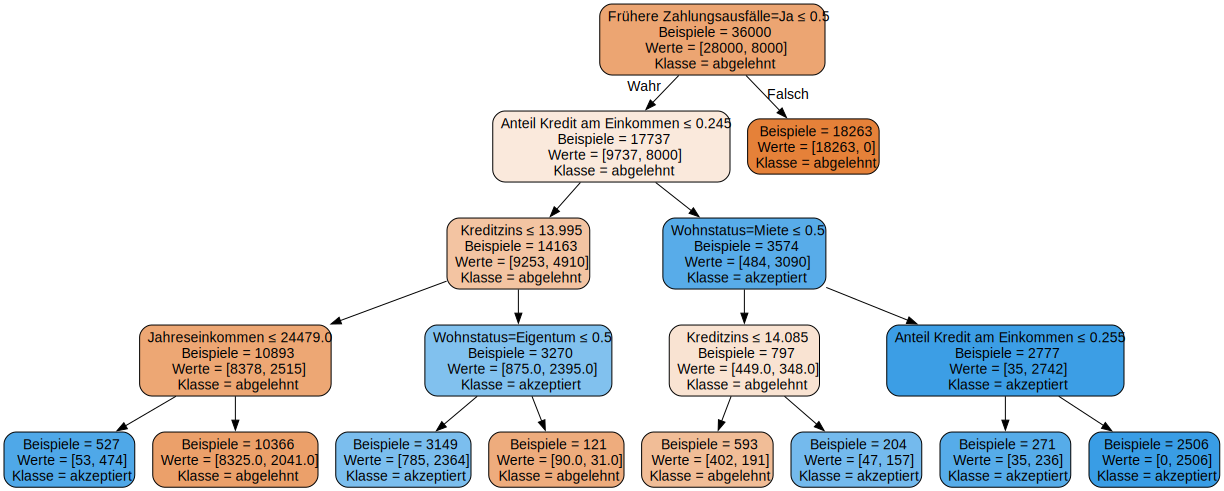

PNG gespeichert als: entscheidungsbaum_kredit_graphviz.png


In [4]:
# Graphviz-Export mit deutschen Knotentexten für den Kredit-Entscheidungsbaum

from sklearn.tree import export_graphviz
import graphviz

# ===== 1) Deutsche Feature-Namen aus dem Preprocessor erzeugen =====
ct = clf.named_steps["preprocess"]
feature_names_out = ct.get_feature_names_out()

# Roh->Deutsch Mapping (wie zuvor)
de_map = {
    "person_age": "Alter",
    "person_gender": "Geschlecht",
    "person_education": "Bildungsgrad",
    "person_income": "Jahreseinkommen",
    "person_emp_exp": "Berufserfahrung (Jahre)",
    "person_home_ownership": "Wohnstatus",
    "loan_amnt": "Kredithöhe",
    "loan_intent": "Kreditabsicht",
    "loan_int_rate": "Kreditzins",
    "loan_percent_income": "Anteil Kredit am Einkommen",
    "cb_person_cred_hist_length": "Kreditvergangenheit (Jahre)",
    "credit_score": "Kredit-Score",
    "previous_loan_defaults_on_file": "Frühere Zahlungsausfälle",
}

# Werteübersetzungen für One-Hot-Spalten (optional erweiterbar)
val_map = {
    "male": "männlich",
    "female": "weiblich",
    "Yes": "Ja",
    "No": "Nein",
    "RENT": "Miete",
    "MORTGAGE": "Hypothek",
    "OWN": "Eigentum",
    "OTHER": "Sonstiges",
    "PERSONAL": "Persönlich",
    "EDUCATION": "Bildung",
    "MEDICAL": "Medizinisch",
    "DEBTCONSOLIDATION": "Schuldenkonsolidierung",
    "VENTURE": "Unternehmensgründung",
    "HOMEIMPROVEMENT": "Hausverbesserung",
}

categorical_cols = [
    "person_gender",
    "person_education",
    "person_home_ownership",
    "loan_intent",
    "previous_loan_defaults_on_file",
]

def germanize_feature_name(name: str) -> str:
    # Beispiel-Eingaben:
    # "num__credit_score" -> "Kredit-Score"
    # "cat__loan_intent_DEBTCONSOLIDATION" -> "Kreditabsicht=Schuldenkonsolidierung"
    if "__" in name:
        _, raw = name.split("__", 1)
    else:
        raw = name

    if "_" in raw and any(raw.startswith(col + "_") for col in categorical_cols):
        col = next(c for c in categorical_cols if raw.startswith(c + "_"))
        val = raw[len(col) + 1:]
        col_de = de_map.get(col, col)
        val_de = val_map.get(val, val)
        return f"{col_de}={val_de}"
    else:
        return de_map.get(raw, raw)

feature_names_de = [germanize_feature_name(n) for n in feature_names_out]

# ===== 2) DOT erzeugen =====
class_names_de = ["abgelehnt", "akzeptiert"]

dot = export_graphviz(
    clf.named_steps["tree"],          # der trainierte DecisionTreeClassifier
    out_file=None,
    feature_names=feature_names_de,   # deutsche Feature-Namen nach Preprocessing
    class_names=class_names_de,
    filled=True,
    rounded=True,
    special_characters=True,
    impurity=False,        # "Gini"/"Entropie" wird gleich eingedeutscht
    proportion=False
)

# ===== 3) Englische Schlüsselwörter → Deutsch =====
translations = {
    "gini =": "Gini =",
    "entropy =": "Entropie =",
    "samples =": "Beispiele =",
    "value =": "Werte =",
    "class =": "Klasse =",
    "False": "Falsch",
    "True": "Wahr",
}
for eng, deu in translations.items():
    dot = dot.replace(eng, deu)

# Mapping für binäre One-Hot-Features
def replace_binary_splits(dot_str: str) -> str:
    # Fall 1: <= 0.5 → = Nein
    dot_str = dot_str.replace("≤ 0.5", "= Nein")
    # Fall 2: > 0.5 → = Ja
    dot_str = dot_str.replace("> 0.5", "= Ja")
    return dot_str

# Transformation anwenden
dot = replace_binary_splits(dot)


# ===== 4) Rendern & Anzeigen =====
graph = graphviz.Source(dot, format="png")
png_path = graph.render("entscheidungsbaum_kredit_graphviz", cleanup=True)  # erzeugt PNG
try:
    display(graph)  # Jupyter-Notebook
except NameError:
    pass

print(f"PNG gespeichert als: {png_path}")


In [6]:
# LIME für Kreditentscheidungen (loan_data.csv) mit Black-Box (MLP) - Versuch
# - Datenebene für LIME: originale Features (inkl. Kategorik)
# - Pipeline: Imputation, One-Hot, Skalierung (für numerisch), MLPClassifier
# - LIME erklärt einzelne Vorhersagen; Export als HTML

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier

from lime.lime_tabular import LimeTabularExplainer

# ===== 1) Daten laden =====
CSV_PATH = "loan_data.csv"
df = pd.read_csv(CSV_PATH)

TARGET = "loan_status"  # 1=approved, 0=rejected
df[TARGET] = pd.to_numeric(df[TARGET], errors="coerce").fillna(0).astype(int)

# ===== 2) Spalten-Setup gemäß deinem Datensatz =====
categorical_cols = [
    "person_gender",
    "person_education",
    "person_home_ownership",
    "loan_intent",
    "previous_loan_defaults_on_file",
]
feature_order = [
    "person_age",
    "person_gender",
    "person_education",
    "person_income",
    "person_emp_exp",
    "person_home_ownership",
    "loan_amnt",
    "loan_intent",
    "loan_int_rate",
    "loan_percent_income",
    "cb_person_cred_hist_length",
    "credit_score",
    "previous_loan_defaults_on_file",
]
numeric_cols = [c for c in feature_order if c not in categorical_cols]

X = df[feature_order].copy()
y = df[TARGET].values

# ===== 3) Train/Test Split =====
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===== 4) Preprocessing + Black-Box-Modell =====
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

black_box = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    random_state=42,
    max_iter=500
)

clf = Pipeline(steps=[("preprocess", preprocess), ("model", black_box)])
clf.fit(X_train_df, y_train)

print(f"Train-Accuracy: {clf.score(X_train_df, y_train):.3f}")
print(f" Test-Accuracy: {clf.score(X_test_df, y_test):.3f}")

# ===== 5) LIME: Kategorien als Integer-Codes + Mapping (für schöne Labels) =====
# Wir lassen LIME in der ORIGINALEN Feature-Ebene arbeiten, aber
# kodieren Kategorik für LIME intern als ints und geben die Namen via 'categorical_names' an.

# Kategorien pro Spalte stabil definieren (auf Basis des Trainings)
cat_levels = {}
for col in categorical_cols:
    # feste Kategorien aus Training (robuster als global, um Leaks zu vermeiden)
    cat_levels[col] = sorted(X_train_df[col].dropna().astype(str).unique().tolist())

# Mapping int <-> cat
int_to_cat = {col: {i: v for i, v in enumerate(cat_levels[col])} for col in categorical_cols}
cat_to_int = {col: {v: i for i, v in int_to_cat[col].items()} for col in categorical_cols}

def to_lime_array(df_like: pd.DataFrame) -> np.ndarray:
    """DataFrame -> NumPy-Array für LIME (categorical -> int-codes, numeric unverändert)."""
    arr = df_like[feature_order].copy()
    for col in categorical_cols:
        arr[col] = arr[col].astype(str).map(cat_to_int[col]).fillna(-1).astype(int)
    return arr.to_numpy()

def from_lime_array(x_arr: np.ndarray) -> pd.DataFrame:
    """NumPy-Array (mit int-codes in Kategorik) -> DataFrame in Original-Strings für die Pipeline."""
    df_back = pd.DataFrame(x_arr, columns=feature_order)
    # Kategorik zurück auf Strings mappen
    for col in categorical_cols:
        df_back[col] = (
            df_back[col]
            .round()
            .astype(int)
            .map(int_to_cat[col])
            .astype(str)
        )
    # Numerik casten (LIME produziert floats – das ist ok)
    for col in numeric_cols:
        df_back[col] = pd.to_numeric(df_back[col], errors="coerce")
    return df_back

# Trainingsdaten für LIME (in der Form, die LIME erwartet)
X_train_lime = to_lime_array(X_train_df)

# Feature-Namen (deutsche Labels optional – hier beispielhaft)
de_map = {
    "person_age": "Alter",
    "person_gender": "Geschlecht",
    "person_education": "Bildungsgrad",
    "person_income": "Jahreseinkommen",
    "person_emp_exp": "Berufserfahrung (Jahre)",
    "person_home_ownership": "Wohnstatus",
    "loan_amnt": "Kredithöhe",
    "loan_intent": "Kreditabsicht",
    "loan_int_rate": "Kreditzins",
    "loan_percent_income": "Anteil Kredit am Einkommen",
    "cb_person_cred_hist_length": "Kreditvergangenheit (Jahre)",
    "credit_score": "Kredit-Score",
    "previous_loan_defaults_on_file": "Frühere Zahlungsausfälle",
}
feature_names_de = [de_map.get(f, f) for f in feature_order]

# Indizes der kategorialen Features bezogen auf feature_order:
categorical_features_idx = [feature_order.index(c) for c in categorical_cols]

# Namen der Kategorien für LIME (deutsch, wenn gewünscht)
# (Die Reihenfolge in den Listen MUSS der int-Codierung entsprechen!)
val_map_de = {
    "male": "männlich",
    "female": "weiblich",
    "Yes": "Ja",
    "No": "Nein",
    "RENT": "Miete",
    "MORTGAGE": "Hypothek",
    "OWN": "Eigentum",
    "OTHER": "Sonstiges",
    "PERSONAL": "Persönlich",
    "EDUCATION": "Bildung",
    "MEDICAL": "Medizinisch",
    "DEBTCONSOLIDATION": "Schuldenkonsolidierung",
    "VENTURE": "Unternehmensgründung",
    "HOMEIMPROVEMENT": "Hausverbesserung",
}
categorical_names = {}
for col in categorical_cols:
    idx = feature_order.index(col)
    names = [val_map_de.get(v, v) for v in int_to_cat[col].values()]
    categorical_names[idx] = names

# ===== 6) Vorhersage-Wrapper für LIME =====
def predict_proba_lime(x_arr: np.ndarray) -> np.ndarray:
    """LIME -> Pipeline.predict_proba; x_arr hat int-codierte Kategorik."""
    df_back = from_lime_array(x_arr)
    return clf.predict_proba(df_back)

class_names_de = ["abgelehnt", "akzeptiert"]  # 0, 1

# ===== 7) LIME-Explainer erstellen =====
explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=feature_names_de,
    class_names=class_names_de,
    categorical_features=categorical_features_idx,
    categorical_names=categorical_names,
    discretize_continuous=True,   # Kontinuierliche Variablen werden sinnvoll gebinnt (quartiles)
    mode="classification",
    verbose=False
)


Train-Accuracy: 0.946
 Test-Accuracy: 0.909


Wahr: akzeptiert | Vorhersage: abgelehnt


HTML gespeichert unter: C:\Users\JuliusSchmidt\Desktop\Modelle und Datenanalyse Masterarbeit\XAI-Modelle\lime_erklärung_kredit_instance.html

Top-Beiträge (Feature -> Beitrag) für Label: akzeptiert
Frühere Zahlungsausfälle=Nein                                +0.3220
8.59 < Kreditzins <= 11.01                                   -0.0717
Wohnstatus=Miete                                             +0.0655
Kreditabsicht=Hausverbesserung                               +0.0592
47163.50 < Jahreseinkommen <= 67081.00                       +0.0408
5000.00 < Kredithöhe <= 8000.00                              -0.0323
0.12 < Anteil Kredit am Einkommen <= 0.19                    -0.0287
Berufserfahrung (Jahre) <= 1.00                              +0.0180
Bildungsgrad=Bachelor                                        -0.0164
Geschlecht=weiblich                                          +0.0150


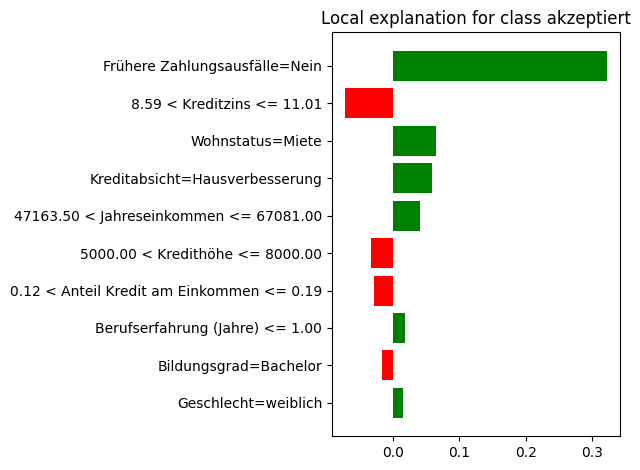

In [7]:
# ===== 8) Eine Instanz erklären =====
X_test_lime = to_lime_array(X_test_df)

i = 120  # oder eine andere Zeile
x_instance = X_test_lime[i]
true_label = y_test[i]
pred_label = clf.predict(from_lime_array(x_instance.reshape(1, -1)))[0]
print("Wahr:", class_names_de[true_label], "| Vorhersage:", class_names_de[pred_label])

# Nur EIN Label erklären (z. B. 1 = akzeptiert)
label_of_interest = 1  # 0 = abgelehnt, 1 = akzeptiert
exp = explainer.explain_instance(
    data_row=x_instance,
    predict_fn=predict_proba_lime,
    num_features=10,
    labels=[label_of_interest]  # <- nur diese Klasse wird erklärt
)

# HTML speichern (ACHTUNG: 'labels' als Liste übergeben!)
from pathlib import Path
out_html = Path("lime_erklärung_kredit_instance.html")
with open(out_html, "w", encoding="utf-8") as f:
    f.write(exp.as_html(labels=[label_of_interest]))

print(f"HTML gespeichert unter: {out_html.resolve()}")

# Konsolenliste der Beiträge
print("\nTop-Beiträge (Feature -> Beitrag) für Label:", class_names_de[label_of_interest])
for feat, weight in exp.as_list(label=label_of_interest):
    print(f"{feat:60s} {weight:+.4f}")

import matplotlib.pyplot as plt

fig = exp.as_pyplot_figure(label=label_of_interest)
plt.tight_layout()
plt.savefig("lime_erklärung_kredit_instance.png", dpi=200, bbox_inches="tight")
plt.show()
